In [1]:
import numpy as np
import jax.numpy as jnp
from jax import nn, jacfwd, jit, vmap, lax, random
from jax.scipy.stats.norm import cdf, pdf
from functools import partial

from scipy.optimize import minimize 

import time

from scipy.stats import linregress
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler

# update plot parameters
params = {'legend.fontsize': 12,
          'figure.figsize': (12, 9),
          'lines.linewidth':4,
         'axes.labelsize': 20,
         'axes.titlesize':24,
          'axes.linewidth':2,
         'xtick.labelsize':22,
         'ytick.labelsize':22}
plt.rcParams.update(params)
plt.rcParams['pdf.fonttype'] = 42

np.random.seed(123)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-dcgh2f7b because the default path (/home/jaron/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# def kernel(xn, xm, params):
#     p0, p1, p2, p3 = params
#     # eqn 6.63 in PRML
#     return p0*jnp.exp(-p1/2 * jnp.dot(xn-xm, xn-xm)) + p2 + p3*jnp.dot(xn, xm) 
                      
# def kernel(xn, xm, params):
#     p0, p1 = params
#     return jnp.tanh(p0*jnp.dot(xn, xm) + p1)

def kernel(xn, xm, variance):
    # eqn 6.23 in PRML
    return jnp.exp(-variance[0] * jnp.dot(xn-xm, xn-xm))

class GP:
    
    def __init__(self, kernel, params, beta):
        self.kernel = jit(kernel)
        self.params = params
        self.beta = beta
        
        # jit compile function to compute covariance
        self.k = jit(vmap(kernel, (0,0,None)))
        self.K = jit(vmap(vmap(kernel, (0, None, None)), (None, 0, None)))
        
        # gradient of covariance matrix w.r.t. kernel parameters
        self.Cgrad = jit(jacfwd(self.K, 2))
    
    def fit(self, X, y, tol=1e-3):
        # objective is to maximize the log-likelihood w.r.t. kernel parameters
        
        # X is an n x m matrix with n observations each with m features 
        # y is an n x 1 matrix with n observations of single variable response 
        self.X = X
        self.y = y.ravel()
        n, m = self.X.shape
        
        # define function to return log-likelihood and its gradient w.r.t. kernel parameters 
        @jit
        def objective(params):
            # covariance 
            C = jnp.eye(n)/self.beta + self.K(self.X, self.X, params)
            C = (C + C.T)/2.
            
            # precision
            Cinv = jnp.linalg.inv(C)
            Cinv = (Cinv + Cinv.T)/2.
            
            # gradient of covariance matrix
            Cgrad = self.Cgrad(self.X, self.X, params)
            
            # negative log likelihood of data given parameters 
            NLL = jnp.nansum(jnp.log(jnp.linalg.eigvalsh(C))) + self.y@Cinv@self.y
            
            # gradient of negative log likelihood
            gradNLL = jnp.trace(Cinv@Cgrad) - jnp.einsum('n,nm,mol,op,p->l',self.y,Cinv,Cgrad,Cinv,self.y)
            
            return NLL, gradNLL
        
        # use Scipy's minimize to find optimal parameters
        res = minimize(objective, self.params, jac=True, tol=tol)
        # print(res)
        self.params = res.x
        
        # compute inverse covariance matrix using optimal parameters
        self.Cinv = np.linalg.inv(jnp.eye(n)/self.beta + self.K(X, X, self.params))
             
    def predict(self, Xtest):
        # Xtest has dimensions [l samples x d features]
        
        # k_ij = kernel(X_test[i], X_train[j])
        k = self.K(self.X, Xtest, self.params)

        # c_ij = kernel(X_test[i], X_test[j]) + 1/beta 
        c = self.k(Xtest, Xtest, self.params) # + 1/self.beta 
        
        # predict mean
        m = jnp.einsum('lm,mn,n->l', k, self.Cinv, self.y)
        
        # predict variance
        v = np.clip(c - jnp.einsum('ln,nm,lm->l', k, self.Cinv, k), 0, np.inf) + 1/self.beta
        
        return m, jnp.sqrt(v)
    
    def conditioned_stdv(self, Xtest, X, Cinv):
        # k_ij = kernel(X_test[i], X_train[j])
        k = self.K(X, Xtest, self.params)

        # c_ij = kernel(X_test[i], X_test[j]) + 1/beta 
        c = self.k(Xtest, Xtest, self.params) # + 1/self.beta
        
        # predict variance
        v = np.clip(c - jnp.einsum('ln,nm,lm->l', k, Cinv, k), 0, np.inf) # + 1/self.beta
        
        return jnp.sqrt(v)
    
    # return indeces of optimal samples
    def search(self, data, objective, N, max_reps=3, batch_size = 512, exploit=True):

        # initialize X matrix to condition on 
        X = self.X.copy()
        Cinv = self.Cinv.copy()
        
        # determine number of samples to search over
        n_samples = data.shape[0]
        batch_size = min([n_samples, batch_size])

        # make predictions once
        all_preds  = []
        for batch_inds in np.array_split(np.arange(n_samples), n_samples//batch_size):
            # make predictions on data
            all_preds.append(self.predict(data[batch_inds])[0])
        
        # compute objective (f: R^[n_t, n_o, w_exp] -> R) in batches
        objective_batch = jit(vmap(lambda pred, stdv: objective(pred, stdv), (0,0)))

        # search for new experiments until find N
        best_experiments = []
        while len(best_experiments) < N:
            
            # compute utilities in batches to avoid memory problems
            utilities = []
            for preds, batch_inds in zip(all_preds, np.array_split(np.arange(n_samples), n_samples//batch_size)):
                stdvs = self.conditioned_stdv(data[batch_inds], X, Cinv)
                if exploit:
                    utilities.append(objective_batch(preds, stdvs))
                else:
                    utilities.append(stdvs)
            utilities = jnp.concatenate(utilities)
            # print("Top 5 utilities: ", jnp.sort(utilities)[::-1][:5])
            
            #plt.plot(np.array(utilities).ravel())

            # pick an experiment
            # print(f"Picked experiment {len(best_experiments)} out of {N}")
            exp = np.argmax(utilities)

            # add experiment to the list 
            if sum(np.in1d(best_experiments, exp)) < max_reps:
                best_experiments += [exp.item()]

                # append datapoint to X
                X = np.concatenate((X, np.expand_dims(data[exp], 0)))

                # update inverse
                Cinv = np.linalg.inv(jnp.eye(X.shape[0])/self.beta + self.K(X, X, self.params))
                
            elif exploit:
                print("Max replicates exceeded, switching to pure exploration")
                exploit=False
            else:
                print("Max exploration replicates exceeded, terminating")
                return best_experiments

        return np.sort(best_experiments)

In [3]:
# COSINES
def f(x):
    x, y = x
    u = 1.6*x - .5
    v = 1.6*y - .5
    return 1 - (u**2 + v**2 - .3*np.cos(3*np.pi*u) - .3*np.cos(3*np.pi*v))

# ROSENBROCK
# def f(x):
#     x, y = x
#     return 10 - 100*(y - x**2)**2 - (1-x)**2

def generate_data(X, noise=0.):
    Nsamples = X.shape[0]
    Y = np.zeros([Nsamples, 1])
    
    for i in range(Nsamples):
        # add some standard Gaussian noise to Y
        Y[i] = f(X[i]) + noise*np.random.randn()

    return Y

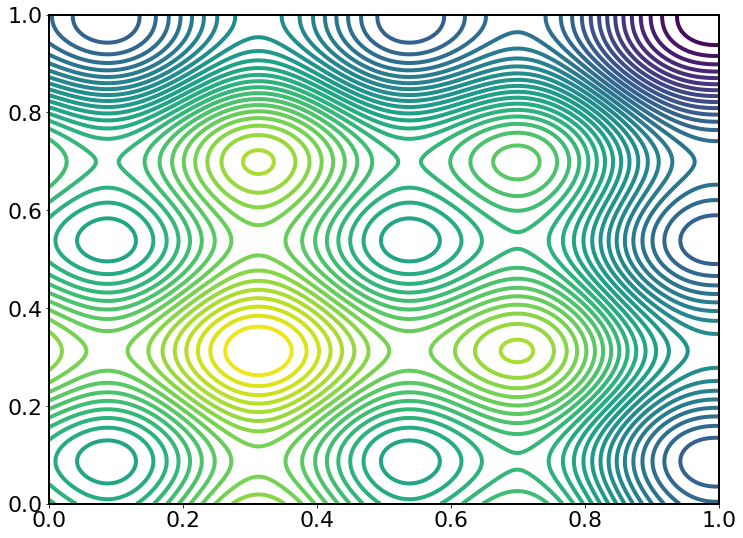

In [4]:
# define design space
n_grid = 200
F_grid = np.zeros([n_grid, n_grid])
X = np.linspace(0, 1, n_grid)
Y = np.linspace(0, 1, n_grid)
Xmesh,Ymesh = np.meshgrid(X,Y)

# test datapoints
X_design = np.stack([Xmesh.ravel(), Ymesh.ravel()]).T
Y_design = generate_data(X_design)

for i, xi in enumerate(X):
    for j, yj in enumerate(Y):
        F_grid[j,i] = f([xi,yj])
        
plt.contour(Xmesh, Ymesh, F_grid, levels=np.linspace(np.min(F_grid), np.max(F_grid), n_grid//5))   
plt.savefig("Results/objective.pdf")
plt.show()

In [5]:
# define number of test points
n_init = 5
n_test = 5
n_cycles = 9
noise = .05
beta  = 1. / noise**2 # precision = inverse variance of noise 

# train data points
X_train = np.random.uniform(size=[n_init, 2])
Y_train = generate_data(X_train, noise=noise)

In [6]:
def NLL(self, params):
    # covariance 
    C = jnp.eye(self.X.shape[0])/self.beta + self.K(self.X, self.X, params)
    C = (C + C.T)/2.

    # precision
    Cinv = np.linalg.inv(C)
    Cinv = (Cinv + Cinv.T)/2.

    # negative log likelihood of data given parameters 
    nll = np.nansum(np.log(np.linalg.eigvalsh(C))) + self.y@Cinv@self.y
    
    return nll

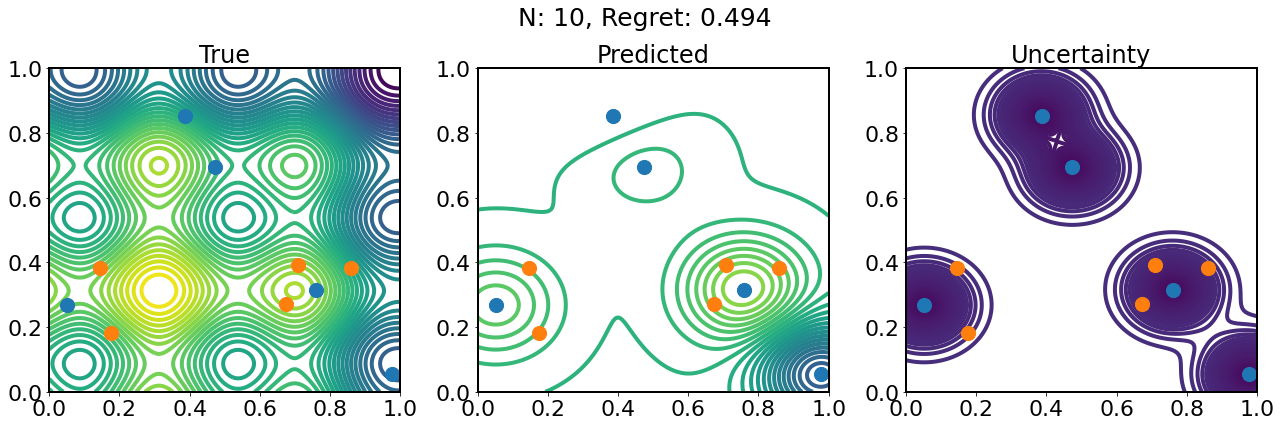

Max replicates exceeded, switching to pure exploration


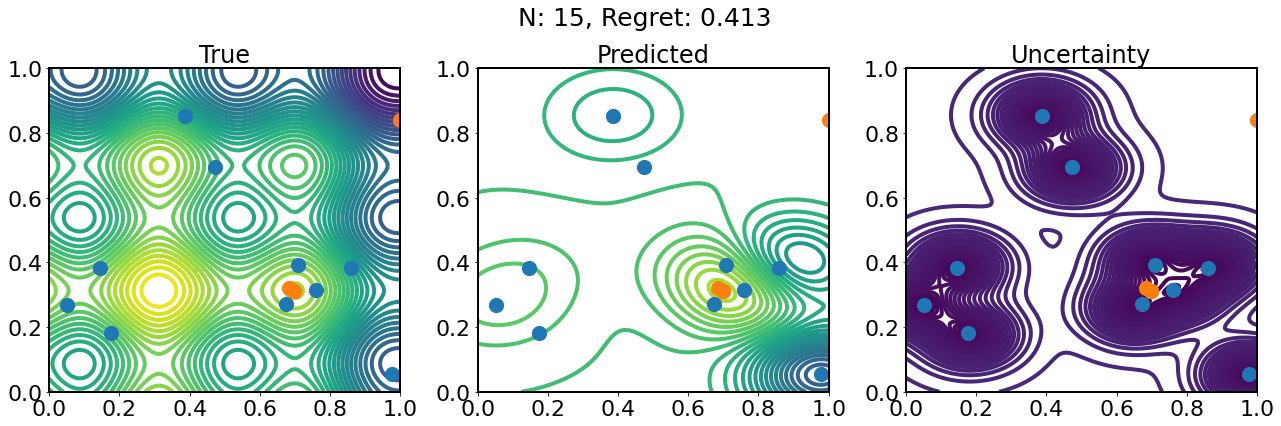

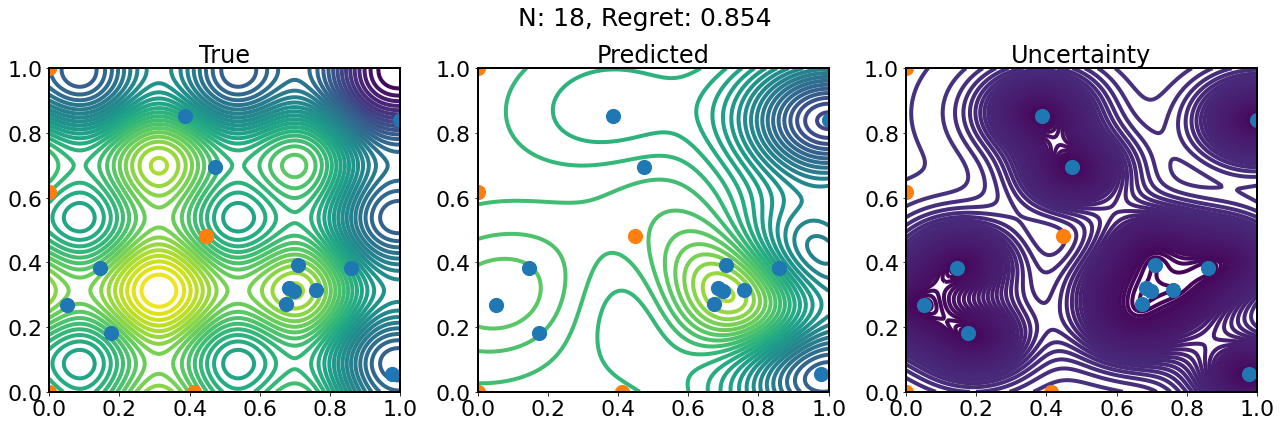

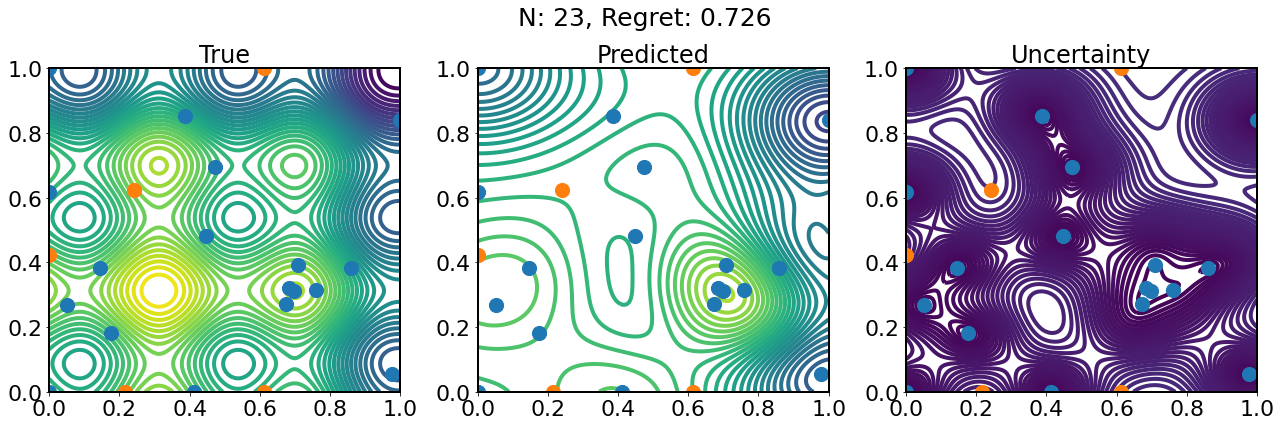

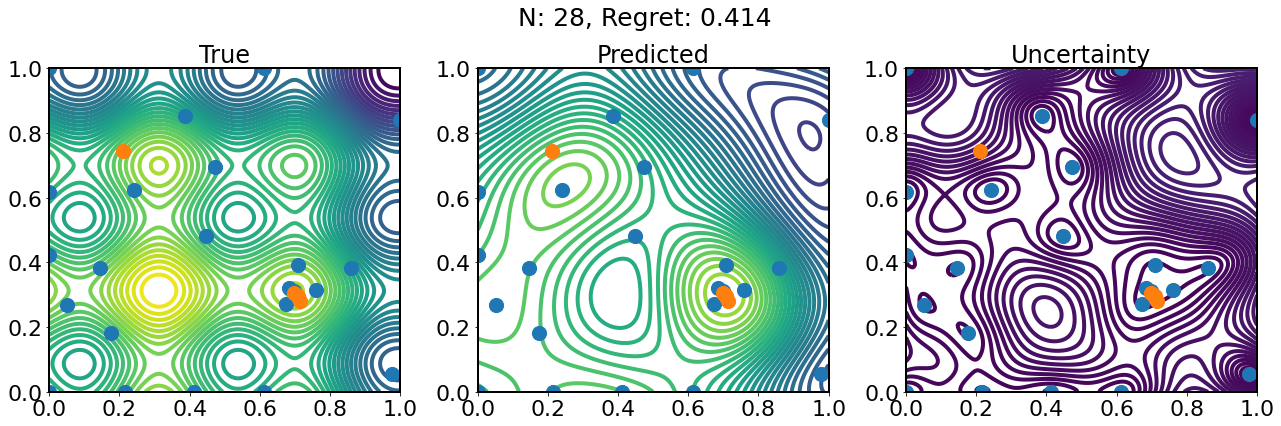

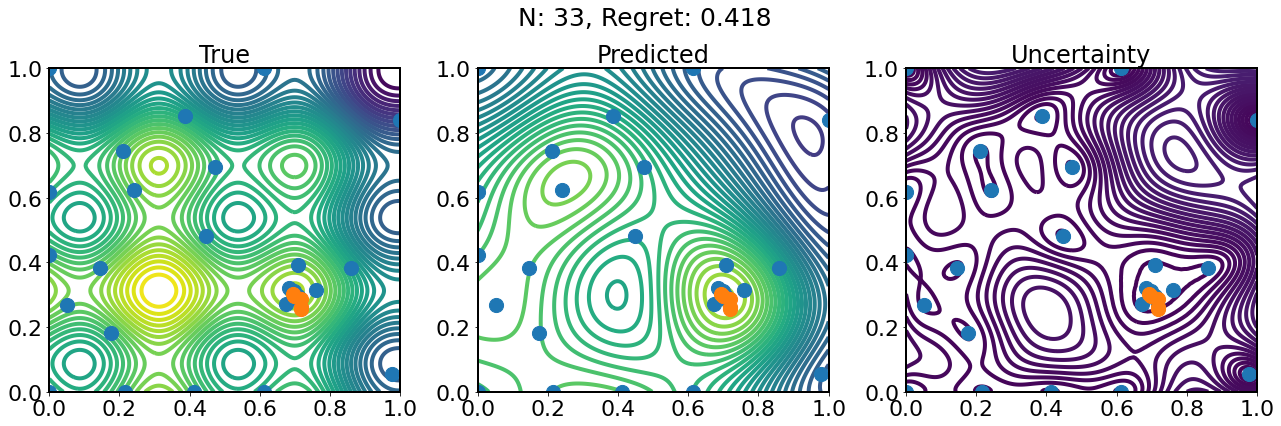

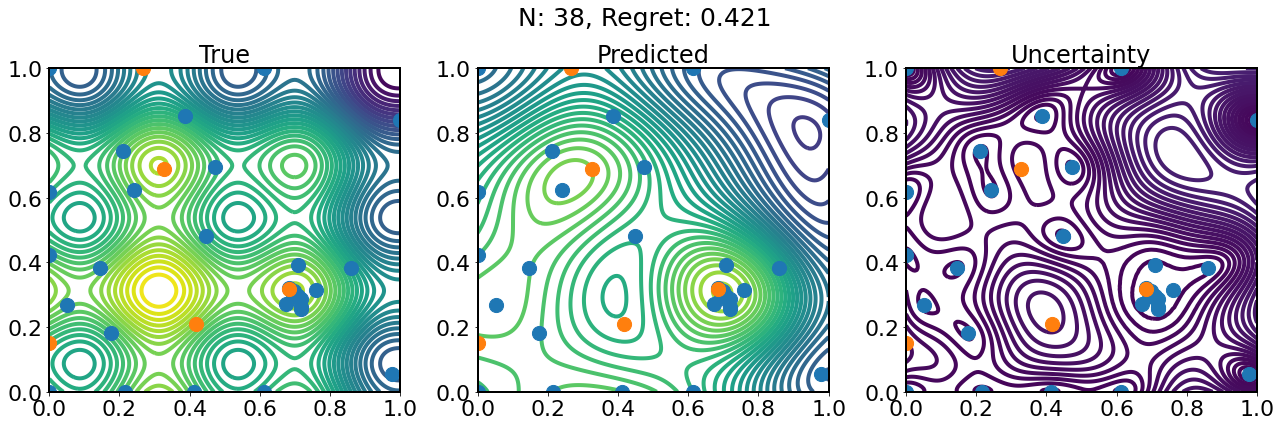

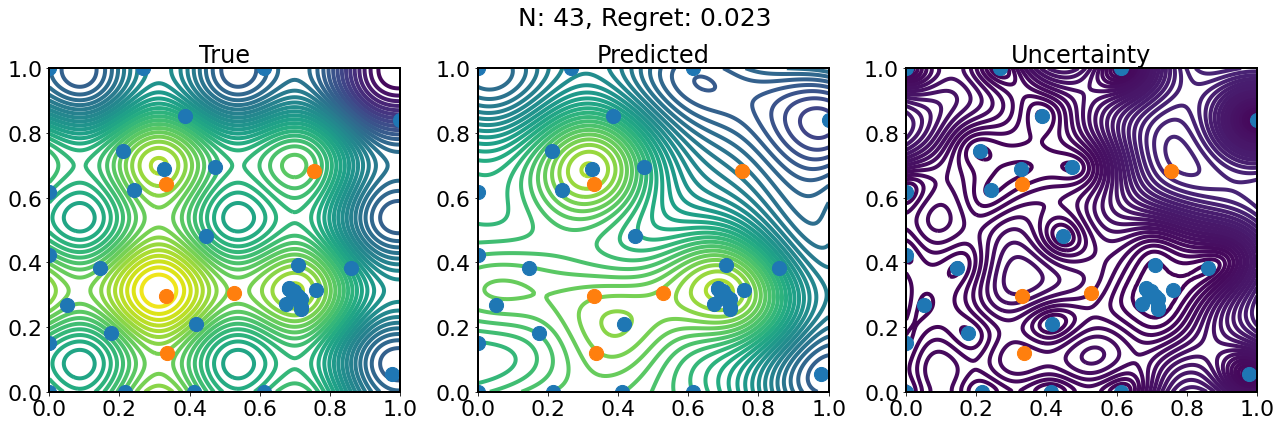

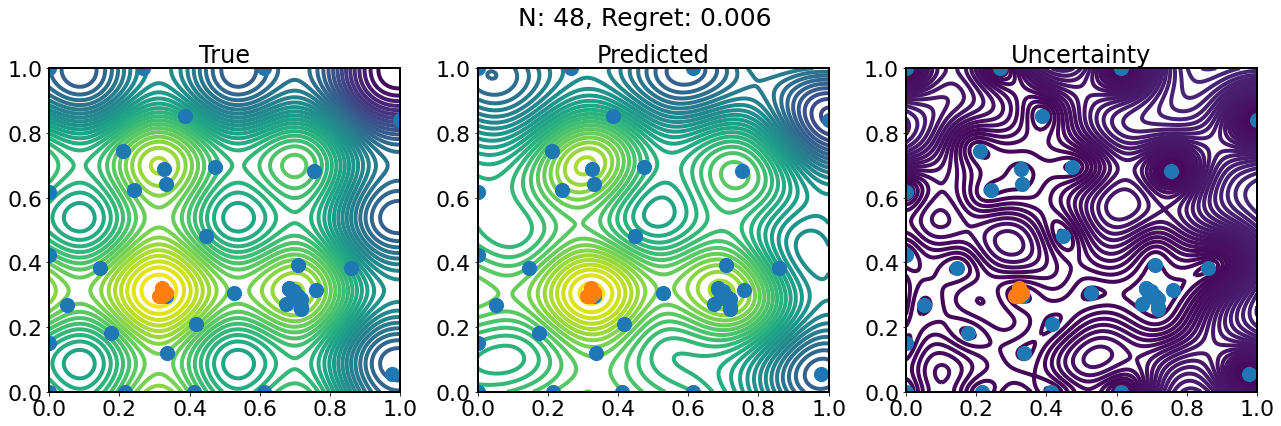

In [7]:
stdv_levels = np.exp(.15*np.linspace(0, 20, n_grid//5)) -1 

for i in range(n_cycles):
    # scale data
    Xscaler = StandardScaler().fit(X_train)
    X_train = Xscaler.transform(X_train)
    X_test  = Xscaler.transform(X_design)

    Yscaler = StandardScaler().fit(np.vstack(Y_train))
    Y_train = Yscaler.transform(np.vstack(Y_train))
    Y_test  = Yscaler.transform(np.vstack(Y_design))

    n_inputs = X_train.shape[1]
    n_outputs = Y_train.shape[1]

    # init Gaussian process
    gp = GP(kernel, [1], beta)

    # fit to training data 
    gp.fit(X_train, Y_train)

    # plot objectives
    #params = np.linspace(.5, 10, 100)
    #objs = np.array([NLL(gp, [p]) for p in params])
    #plt.plot(params, objs)
    #plt.show()
    
    # Design next experiment

    # Expected improvement objective
    fstar = np.max(Y_train)
    def objective(pred, stdv):
        improvement = pred - fstar
        Z = improvement/stdv
        return improvement*cdf(Z) + stdv*pdf(Z)

    design_inds = gp.search(X_test, objective, n_test)
    X_old = Xscaler.inverse_transform(X_train) 
    Y_old = Yscaler.inverse_transform(Y_train)
    X_new = X_design[design_inds]
    Y_new = Y_design[design_inds]

    # plot model approximation of objective and uncertainty
    Y, Y_stdv = gp.predict(X_test)

    F_pred = np.reshape(Yscaler.inverse_transform(Y), [n_grid, n_grid])
    F_stdv = np.reshape(Yscaler.scale_*Y_stdv, [n_grid, n_grid])
    Y_min = np.min(Y_design)
    Y_max = np.max(Y_design)

    plt.figure(figsize=(18, 6))
    plt.subplot(131)
    plt.contour(Xmesh, Ymesh, F_grid, levels=np.linspace(Y_min, Y_max, n_grid//5), zorder=0)  
    plt.scatter(X_old[:,0], X_old[:,1], s=200, zorder=1)
    plt.scatter(X_new[:,0], X_new[:,1], s=200, zorder=2)
    plt.title("True")

    plt.subplot(132)
    plt.contour(Xmesh, Ymesh, F_pred, levels=np.linspace(Y_min, Y_max, n_grid//5), zorder=0)
    plt.scatter(X_old[:,0], X_old[:,1], s=200, zorder=1)
    plt.scatter(X_new[:,0], X_new[:,1], s=200, zorder=2)
    plt.title("Predicted")

    plt.subplot(133)
    # plt.contour(Xmesh, Ymesh, F_stdv, levels=stdv_levels, zorder=0)
    plt.contour(Xmesh, Ymesh, F_stdv, levels=np.linspace(0., 3*Y_max, n_grid), zorder=0)
    plt.scatter(X_old[:,0], X_old[:,1], s=200, zorder=1)
    plt.scatter(X_new[:,0], X_new[:,1], s=200, zorder=2)
    plt.title("Uncertainty")

    # compute regret
    regret = np.max(Y_design) - np.max(Y_new)
    plt.suptitle("N: {:.0f}, Regret: {:.3f}".format(X_train.shape[0]+X_new.shape[0], regret), fontsize=25)
    plt.tight_layout()
    plt.savefig(f"Results/Cosines_DTL_{i}.pdf")
    plt.show()

    # update training data with new design (AVERAGE OVER REPLICATES)
    
    # matrix to average over replicate samples
    unique_designs, counts = np.unique(design_inds, return_counts=True)
    C = np.zeros([len(unique_designs), len(design_inds)])
    k = 0
    for i,c in enumerate(counts):
        C[i,k:k+c] = 1.
        k += c

    # sample several replicates of response
    Y_new = generate_data(X_new, noise=noise)

    # average over replicates
    X_new = np.einsum('nm,mk,n->nk', C, X_new, 1./counts) 
    Y_new = np.einsum('nm,mk,n->nk', C, Y_new, 1./counts) 
    
    # update training data with new data 
    X_train = np.concatenate((X_old, X_new))
    Y_train = np.concatenate((Y_old, Y_new))